# Reproducing some of the figures of the paper

In the following, we reproduce some of the figures in the paper.

## iRF candidate interactions

You can find the three fitted mode, namely, iRF (iterative Random Forest), RF (regular Random Forest obtained with the R package ranger), and lasso (penalized logistic regression, with L1 penalty), in the results folder. You can load the gene level models as follows. For the SNP level model, replace "SNP" by "gene".

In [25]:
setwd("scripts/")

ERROR: Error in setwd("scripts/"): cannot change working directory


In [9]:
load("../results/analysis_iRF_gene.Rdata") #load the iRF model
load("../results/lasso_analysis_iRF_gene.Rdata") #load the lasso model
load("../results/ranger_analysis_iRF_gene.Rdata") #load the ranger model
ls()

[1] "fit"   "frang" "lasso"

In our red hair analysis, the phenotype test and training data was as follows:

In [12]:
pheno <- c(rep(0, 2000), rep(1, 2000))
pheno.train <- c(rep(0, 16000), rep(1, 16000))

Now we load the predicted responses from the three different model.

In [13]:
load("../results/ypred_analysis_iRF_gene.Rdata")
ls()

[1] "fit"          "frang"        "lasso"        "pheno"        "pheno.train" 
[6] "ypred.irf"    "ypred.lasso"  "ypred.ranger"

Now we generate and plot ROC curves as in the paper.

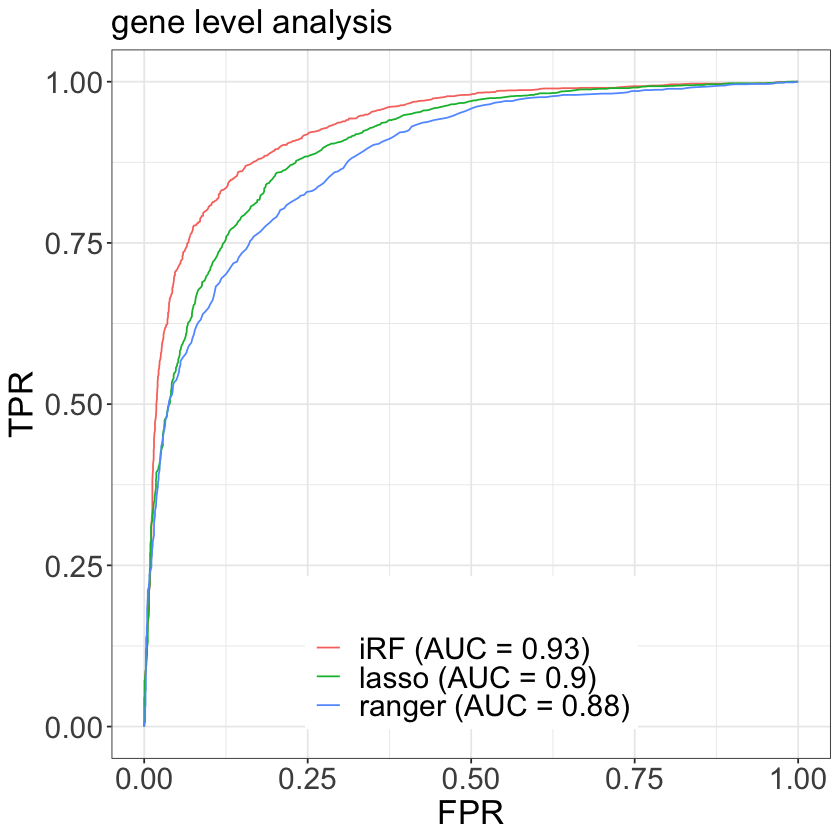

In [16]:
library(PRROC)

roc.curve.lasso.gene <- roc.curve(ypred.lasso[pheno == 1], ypred.lasso[pheno == 0], curve = TRUE)
roc.curve.ranger.gene <- roc.curve(ypred.ranger[pheno == 1], ypred.ranger[pheno == 0], curve = TRUE)
roc.curve.irf.gene <- roc.curve(ypred.irf[pheno == 1], ypred.irf[pheno == 0], curve = TRUE)

source("utilities_figures.R")

plot_gene <- plotCurve(list(roc.curve.lasso.gene, roc.curve.ranger.gene, roc.curve.irf.gene), 
            leg = c("lasso", "ranger", "iRF"), type = 'roc') +
    ggtitle("gene level analysis")

print(plot_gene)

You can obtain all iRF interactions as follows.

In [17]:
head(fit$interaction)

,int,prevalence,precision,cpe,sta.cpe,fsd,sta.fsd,mip,sta.mip,stability
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000003249.9+_ENSG00000258947.2-,0.4581061,0.8428150,0.3723519,1,0.054975580,1,0.09766612,1,1
2,ENSG00000003249.9+_ENSG00000185324.17-,0.3754021,0.8805466,0.3242865,1,-0.006632828,0,0.11879192,1,1
3,ENSG00000003249.9+_ENSG00000204991.6-,0.3419326,0.8191288,0.2661596,1,0.027136898,1,0.07397993,1,1
4,ENSG00000185324.17-_ENSG00000258947.2-,0.2880649,0.8617866,0.2416989,1,-0.008683327,0,0.10003199,1,1
5,ENSG00000003249.9+_ENSG00000141013.10+,0.3116213,0.8028230,0.2348070,1,0.011290376,1,0.05767411,1,1
6,ENSG00000185324.17-_ENSG00000204991.6-,0.2848568,0.8243345,0.2239385,1,0.053123033,1,0.06257982,1,1


In [19]:
path.db <- "../data/gtex_v7_Skin_Sun_Exposed_Lower_leg_imputed_europeans_tw_0.5_signif.db"
source("utilities_loadDB.R")

[1] "Specifify output bim file with list of DB SNPs as: \"path.bim.out\""


In [21]:
head(db.gene.chr.genename)

,gene,name,chr
,<fct>,<fct>,<int>
ENSG00000237491.4,ENSG00000237491.4,RP11-206L10.9,1
ENSG00000230092.3,ENSG00000230092.3,RP11-206L10.8,1
ENSG00000177757.1,ENSG00000177757.1,FAM87B,1
ENSG00000225880.4,ENSG00000225880.4,LINC00115,1
ENSG00000230368.2,ENSG00000230368.2,FAM41C,1
ENSG00000223764.2,ENSG00000223764.2,RP11-54O7.3,1


In [24]:
source("utilities_general.R")

int <- cleanInt(fit$interaction$int)      #remove sign from interaction name
int <- sapply(int, function(x) unlist(str_split(x, '_')))     #individual genes in interaction
ind.db.int <- sapply(int, match, db.gene.chr.genename$gene)     #indexes of interaction genes in data base

ind.stab <- which(apply(fit$interaction, 1, function(x) all(x[10] >= 0.5)))     #indexes of interactions with stability score >= 0.5
ind.ichr <- which(sapply(ind.db.int, function(x) length(unique(db.gene.chr.genename$chr[x]))>1))     #indexes of intra chromosome interactions  

head(fit$interaction[intersect(ind.stab, ind.ichr), ])

int,prevalence,precision,cpe,sta.cpe,fsd,sta.fsd,mip,sta.mip,stability
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000003249.9+_ENSG00000101440.5+,0.09595990,0.7940709,0.07099148,1,-0.013734545,0,0.04892205,1,1.00
ENSG00000101440.5+_ENSG00000185324.17-,0.08907981,0.8067814,0.06767691,1,0.008331981,1,0.04502677,1,1.00
ENSG00000101440.5+_ENSG00000258947.2-,0.07748173,0.7876896,0.05653526,1,-0.007727552,0,0.05556053,1,1.00
ENSG00000003249.9+_ENSG00000101440.5+_ENSG00000258947.2-,0.05785271,0.8748688,0.04955642,1,-0.003532717,0,0.03205377,1,1.00
ENSG00000003249.9+_ENSG00000101440.5+_ENSG00000185324.17-,0.05294045,0.9185153,0.04823083,1,-0.005230269,0,0.03796878,1,0.96
ENSG00000181788.3-_ENSG00000185324.17-,0.05179787,0.8908509,0.04544577,1,0.013518135,1,0.12909629,1,0.54


Note that iRF outputs signed interactions. In the following, we do not consider the sign, after removing the sign, the above 24 interactions reduce the 18 unsigned interactions.

## PCS p-values

Let us load the p-values.

In [30]:
load("../results/pval_all_analysis_iRF_gene.Rdata")
load("../results/pval_analysis_iRF_gene.Rdata")

In [60]:
library(tidyverse)

data <- pValues.intra %>% select(genes, pC, stab.pCart) %>%
                rename(pval = pC, stab = stab.pCart) %>%
                add_column(logLA = sapply(pCart.intra, function(x) attr(x, "logLA")),
                   logLH = sapply(pCart.intra, function(x) attr(x, "logLH"))) 
                                     
head(data)


,genes,pval,stab,logLA,logLH
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,"DBNDD1 , ASIP",9.943737e-05,1.0,-2110.800,-2367.466
2,"ASIP , CDK10",1.000000e+00,0.0,-2433.021,-2411.509
3,"ASIP , TUBB3",1.664944e-04,0.9,-2032.333,-2133.668
4,"DBNDD1 , ASIP , TUBB3",1.000000e+00,0.3,-2093.501,-1930.795
5,"DBNDD1 , ASIP , CDK10",6.361065e-04,0.3,-1940.848,-1995.679
6,"SIAH2 , CDK10",1.000000e+00,0.0,-2418.772,-2418.736


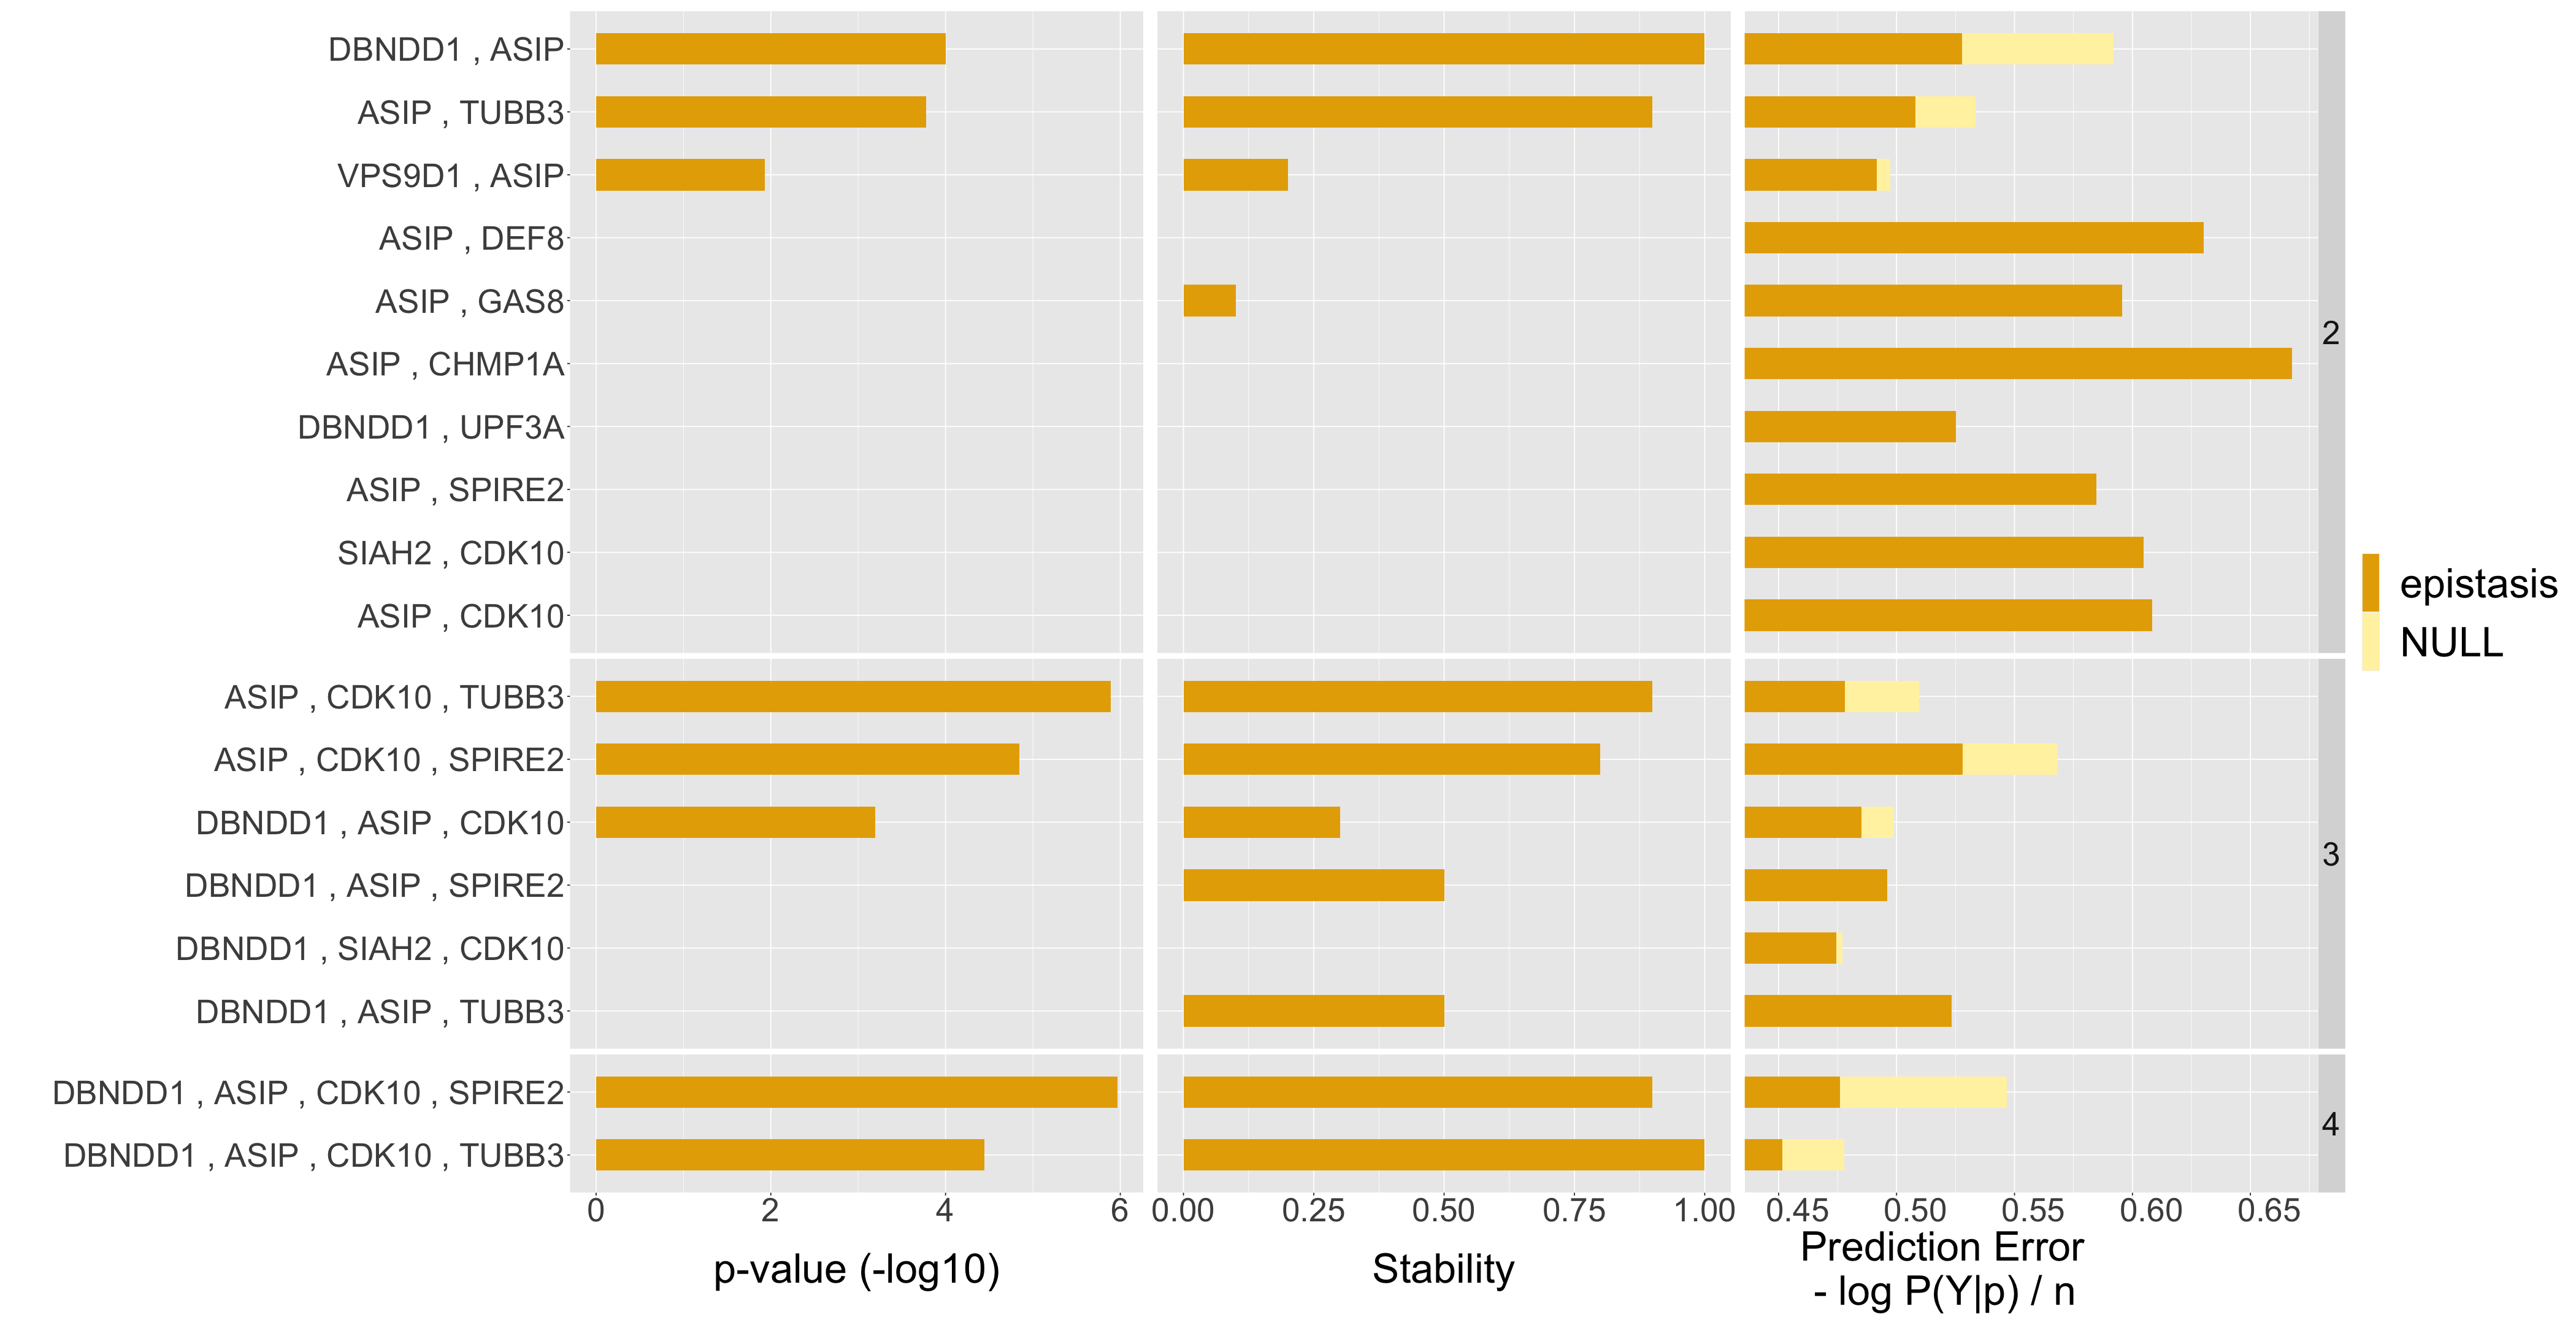

In [61]:
source("utilities_figures.R")
plot_pvalue_table <- plotPvalues(data, n = length(pheno))
ht <- max(12/8 * nrow(data), 15) * 0.5
options(repr.plot.width=35, repr.plot.height=ht)
print(plot_pvalue_table)

We can also look at individual response surfaces. 

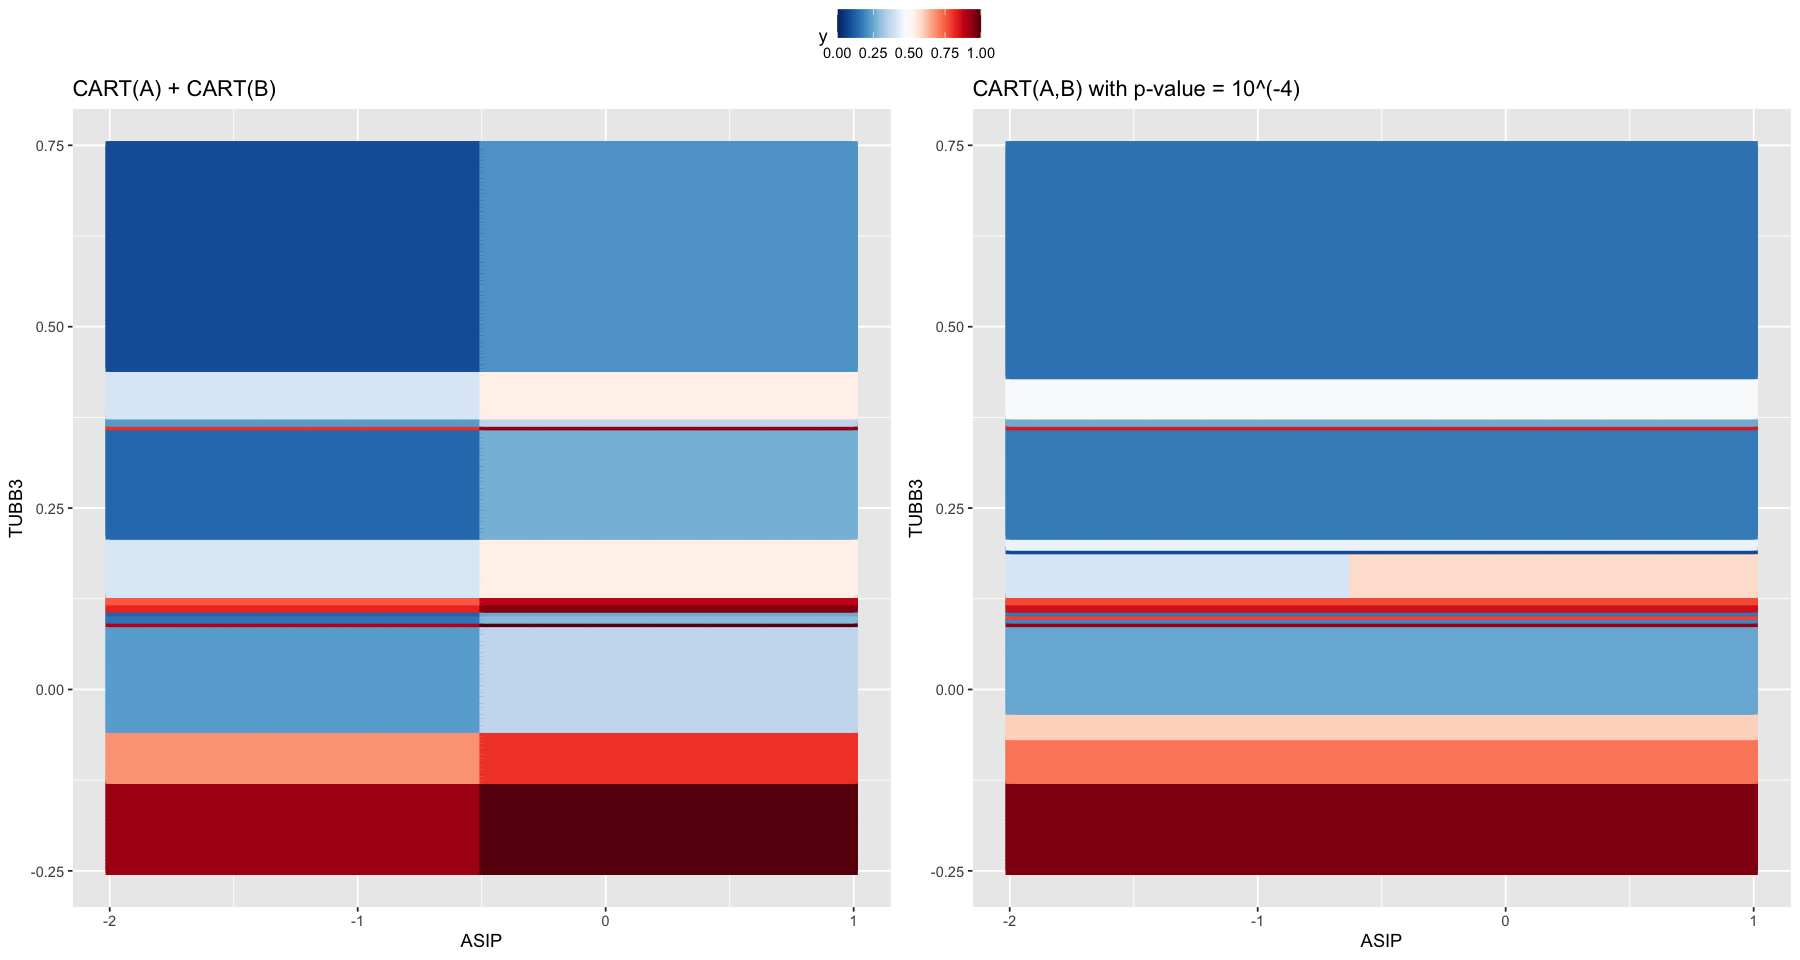

In [71]:
load("../results/CART_models/pval_cart_with_tree_analysis_iRF_gene_interaction_ASIP_TUBB3.Rdata")
source("utilities_figures.R")

plot_response <- plotResponse(pv, range1 = c(-2, 1), range2 = c(-0.25, 0.75))

options(repr.plot.width=15, repr.plot.height=8)
print(plot_response)

Imagine we would have some data. Note that the response surfaces are now plotted at the scale of geno.

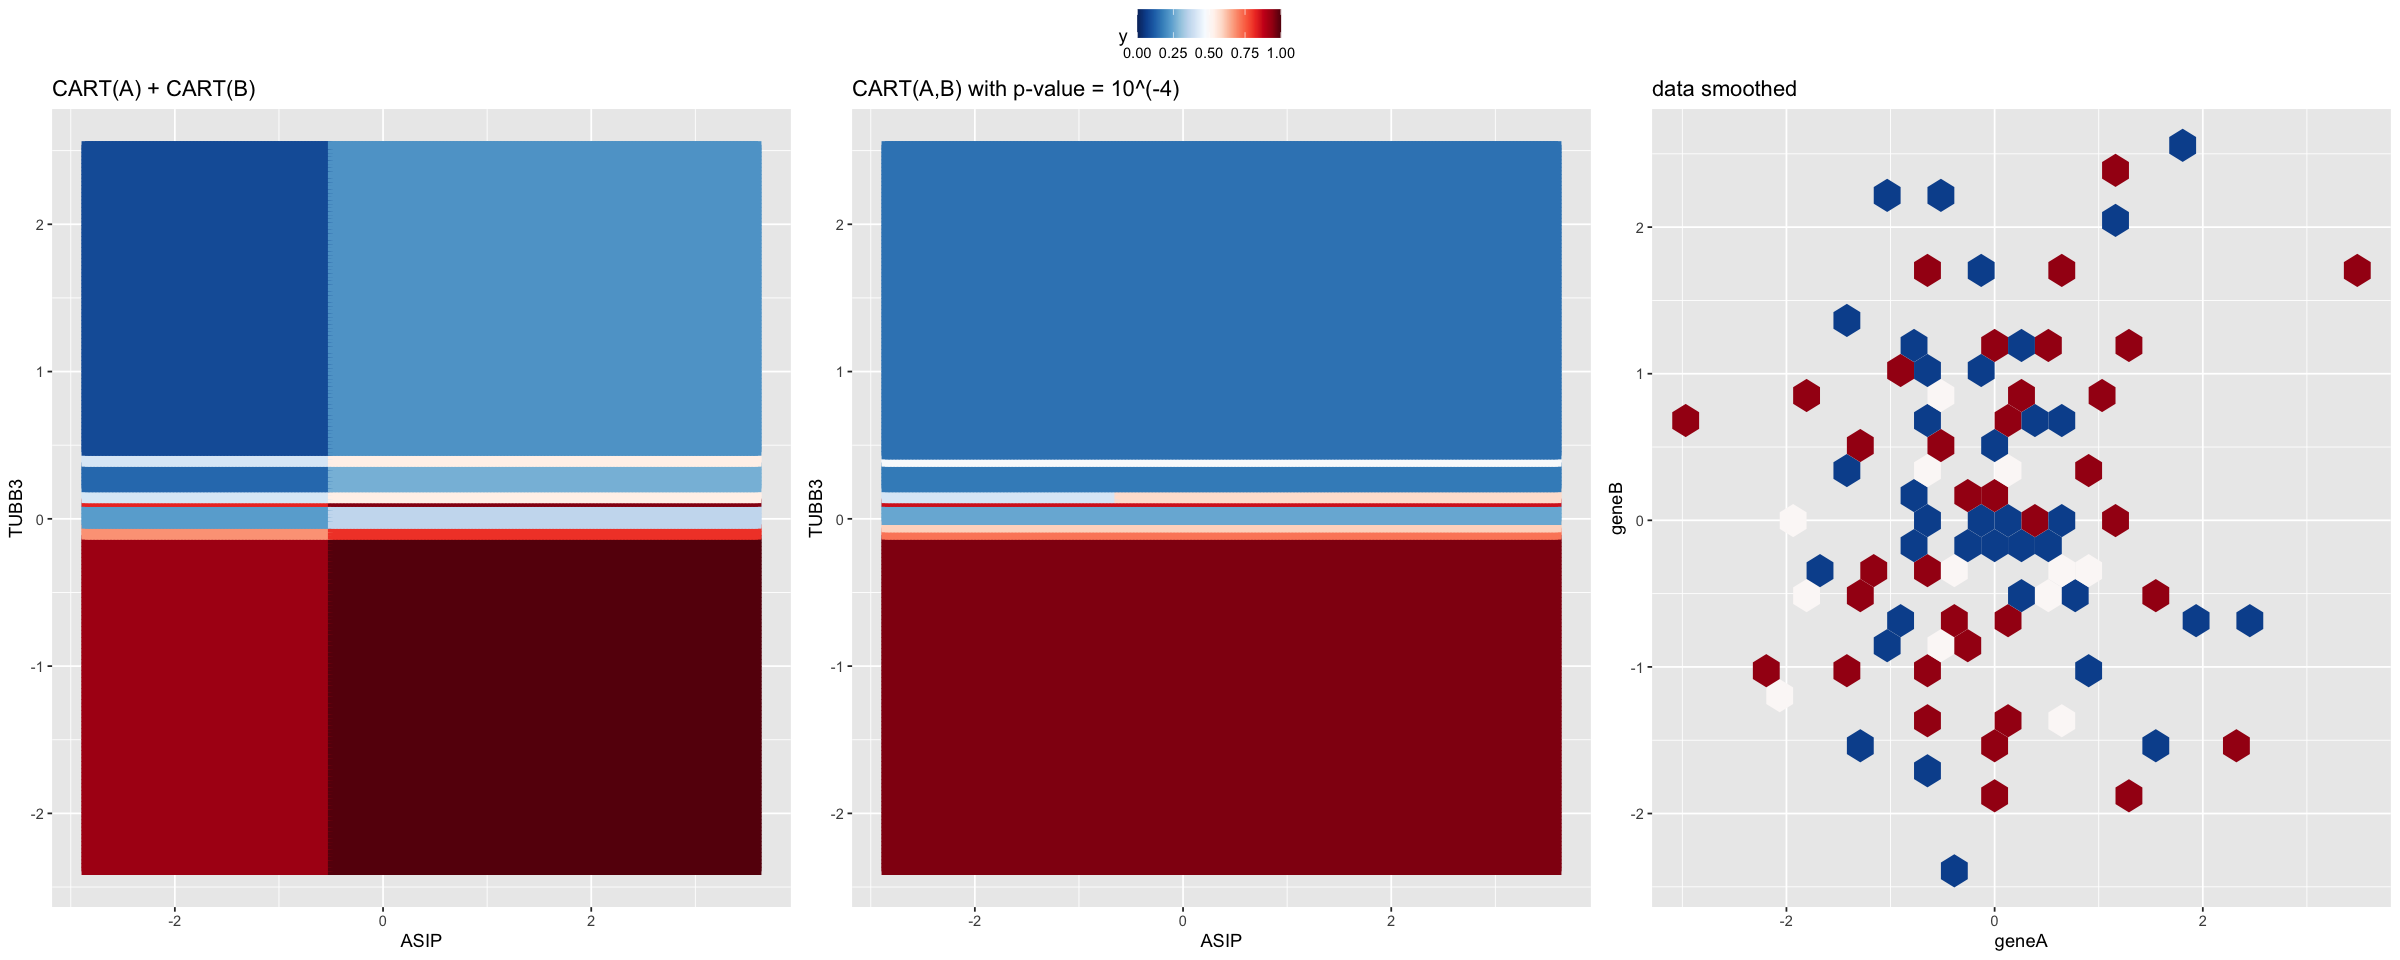

In [77]:
load("../results/CART_models/pval_cart_with_tree_analysis_iRF_gene_interaction_ASIP_TUBB3.Rdata")
source("utilities_figures.R")

data <- list(geno = data.frame(geneA = rnorm(100), geneB = rnorm(100)), pheno = c(rep(1,50), rep(0,50)))

plot_response <- plotResponse(pv, data)

options(repr.plot.width=20, repr.plot.height=8)
print(plot_response)
